### Table of contents

    1. Data sourcing
    2. Data cleaning
    3. Univariate analysis
    4. Derived columns/metrics
    5. Bivariate analysis
    6. Final Conclusion 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format #convert exponential values to float numbers for pandas
pd.set_option('display.max_columns', 100) #Restrict display of columns to 100
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format}) #convert exponential values to float numbers for numpy

import os

import warnings
warnings.filterwarnings('ignore') # if there are any warning due to version mismatch, it will be ignored

### 1. Data sourcing
##### Load the loan.csv file into dataframe

In [2]:
loan_file_path = r"loan.csv"
loan_df=pd.read_csv(loan_file_path, encoding="unicode_escape", delimiter = ",", dtype='object')
loan_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,39717,39717,39717,39717,39717,39717,39717,39717,39717,39717,37258,38642,39717,39717,39717,39717,39717,39717,39717,26777,39717,39706,39717,39717,39717,39717,39717,39717,14035,2786,39717,39717,39717,39667,39717,39717,39717,39717,39717,39717,39717,39717,39717,39717,39717,39646,39717,1140,39715,39661,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39661,39717,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,39020,39678,0.00,0.00,0.00,0.00
unique,39717,39717,885,1041,8205,2,371,15383,7,35,28820,11,5,5318,3,55,3,1,39717,26527,14,19615,823,50,2868,11,526,9,95,111,40,5,21711,1089,82,1,1137,1138,37850,37518,7976,35148,1356,4040,2616,101,34930,2,106,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3,1,0.00,0.00,0.00,0.00
top,616011,1201712,10000,10000,5000,36 months,10.99%,311.11,B,B3,US Army,10+ years,RENT,60000,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,,debt_consolidation,Debt Consolidation,100xx,CA,0,0,Nov-98,0,0,0,7,0,0,0%,16,f,0,0,11196.56943,0,10000,0,0,0,0,May-16,0,Jun-16,May-16,0,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,nan,nan,nan,nan
freq,1,1,2833,2741,1309,29096,956,68,12020,2917,134,8879,18899,1505,16921,2260,32950,39717,1,210,18641,2184,597,7099,183,35405,370,19300,443,670,4018,37601,994,977,1471,39717,38577,38577,26,165,2293,71,37671,35499,35935,1256,74,1125,10308,39661,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,39661,39717,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,37339,39678,nan,nan,nan,nan


### 2. Data Cleaning
    1. Fix rows and columns
    2. Fix missing values
    3. Standardize values
    4. Fix invalid values
    5. Filter data

Note: There are 111 columns and not every column has different amount of NA values checking for only those columns whose NA values are more than 50%. We can potentially get rid of these columns.

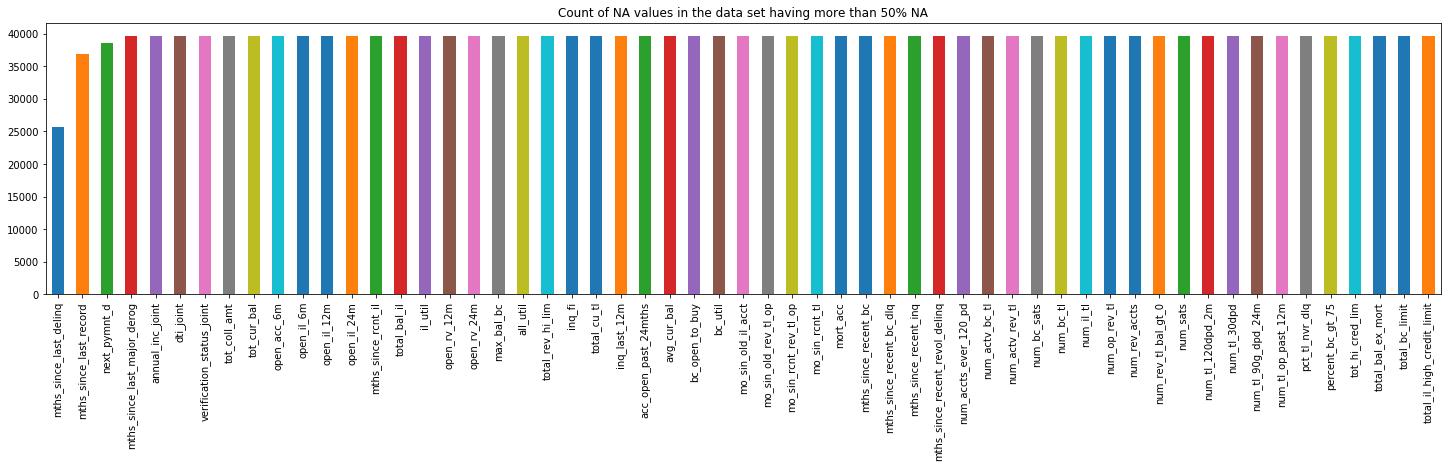

In [3]:
#Count of NA values in the data set.
na_col = loan_df.isnull().sum()
na_col = na_col[na_col.values >(0.5*len(loan_df))]
plt.figure(figsize=(25,5))
na_col.plot(kind='bar')
plt.title('Count of NA values in the data set having more than 50% NA')
plt.show()

In [4]:
#fucntion for remove NA/nulls based on above analysis of columns whose NA values rise upto 50%
def removeNulls(dataframe, axis =1, percent=0.1):
    '''
    * removeNull function will remove the rows and columns based on parameters provided.
    * dataframe : Name of the dataframe  
    * axis      : axis = 0 drops rows, axis =1(default) drops columns    
    * percent   : percent of data where column/rows values are null, by default passing 10% unless specified
              
    '''
    df = dataframe.copy()
    ishape = df.shape
    if axis == 0:
        rownames = df.transpose().isnull().sum()
        rownames = list(rownames[rownames.values > percent*len(df)].index)
        df.drop(df.index[rownames],inplace=True) 
        print("\nNumber of Rows dropped\t: ",len(rownames))
    else:
        colnames = (df.isnull().sum()/len(df))
        colnames = list(colnames[colnames.values>=percent].index)
        df.drop(labels = colnames,axis =1,inplace=True)        
        print("Number of Columns dropped\t: ",len(colnames))
        
    print("\nOld dataset rows,columns",ishape,"\nNew dataset rows,columns",df.shape)

    return df

### 2.1 Remove columns whose NA values more 50%

In [5]:
loan_without_na = removeNulls(loan_df, axis = 1, percent = 0.5)

Number of Columns dropped	:  57

Old dataset rows,columns (39717, 111) 
New dataset rows,columns (39717, 54)


##### Inference: We have come down from 111 columns to 54

### 2.2 Remove rows whose NA values more 50%

In [6]:
loan_without_na = removeNulls(loan_without_na, axis = 0, percent = 0.5)


Number of Rows dropped	:  0

Old dataset rows,columns (39717, 54) 
New dataset rows,columns (39717, 54)


##### Inference: No rows dropped

### 2.3 Remove columns whose values same throughout or have just one value for all columns

In [7]:
loan_unique = loan_without_na.nunique()
loan_unique = loan_unique[loan_unique.values == 1]
loan_without_na.drop(labels = list(loan_unique.index), axis =1, inplace=True)
print("So now we are left with",loan_without_na.shape ,"rows & columns.")

So now we are left with (39717, 45) rows & columns.


##### Inference: Columns have further come down to 45 from 54

### 2.4 Removing columns which are not required for analysis

In [8]:
not_required_columns = ["id","member_id","url","zip_code","desc"]
loan_dropped_col = loan_without_na.drop(labels = not_required_columns, axis =1, inplace=False)
print("So now we are left with", loan_dropped_col.shape ,"rows & columns.")

So now we are left with (39717, 40) rows & columns.


##### Inference: From 45 columns now down to 40

##### emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. So we are assuming that any NA will be considered as 'self-employed' which is 0 years of employment. Replace all nan in emp_length to 0

In [9]:
print(loan_without_na.emp_length.unique())
loan_without_na.emp_length.fillna('0',inplace=True)
print(loan_without_na.emp_length.unique())

['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' nan]
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years' '0']


In [10]:
#keeping a copy of original data frame
loan_num = loan_dropped_col

#removing string % and converting to float values (not dividing by 100, just making them float values)
loan_num['int_rate'] = loan_num['int_rate'].str.rstrip('%').astype('float')
loan_num.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000,Verified,Dec-11,Fully Paid,credit_card,Computer,AZ,27.65,0,Jan-85,1,3,0,13648,83.70%,9,0,0,5863.155187,5833.84,5000,863.16,0,0,0,Jan-15,171.62,May-16,0
1,2500,2500,2500,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,Dec-11,Charged Off,car,bike,GA,1,0,Apr-99,5,3,0,1687,9.40%,4,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-13,119.66,Sep-13,0
2,2400,2400,2400,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252,Not Verified,Dec-11,Fully Paid,small_business,real estate business,IL,8.72,0,Nov-01,2,2,0,2956,98.50%,10,0,0,3005.666844,3005.67,2400,605.67,0,0,0,Jun-14,649.91,May-16,0
3,10000,10000,10000,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,Source Verified,Dec-11,Fully Paid,other,personel,CA,20,0,Feb-96,1,10,0,5598,21%,37,0,0,12231.89,12231.89,10000,2214.92,16.97,0,0,Jan-15,357.48,Apr-16,0
4,3000,3000,3000,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000,Source Verified,Dec-11,Current,other,Personal,OR,17.94,0,Jan-96,0,15,0,27783,53.90%,38,524.06,524.06,3513.33,3513.33,2475.94,1037.39,0,0,0,May-16,67.79,May-16,0


### 2.5 Type case all number columns to numeric

In [11]:
numeric_columns = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','int_rate','annual_inc','dti']

loan_num[numeric_columns] = loan_num[numeric_columns].apply(pd.to_numeric)
loan_num.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,5000,5000,4975.00,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-11,Fully Paid,credit_card,Computer,AZ,27.65,0,Jan-85,1,3,0,13648,83.70%,9,0,0,5863.155187,5833.84,5000,863.16,0,0,0,Jan-15,171.62,May-16,0
1,2500,2500,2500.00,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,car,bike,GA,1.00,0,Apr-99,5,3,0,1687,9.40%,4,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-13,119.66,Sep-13,0
2,2400,2400,2400.00,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-11,Fully Paid,small_business,real estate business,IL,8.72,0,Nov-01,2,2,0,2956,98.50%,10,0,0,3005.666844,3005.67,2400,605.67,0,0,0,Jun-14,649.91,May-16,0
3,10000,10000,10000.00,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-11,Fully Paid,other,personel,CA,20.00,0,Feb-96,1,10,0,5598,21%,37,0,0,12231.89,12231.89,10000,2214.92,16.97,0,0,Jan-15,357.48,Apr-16,0
4,3000,3000,3000.00,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-11,Current,other,Personal,OR,17.94,0,Jan-96,0,15,0,27783,53.90%,38,524.06,524.06,3513.33,3513.33,2475.94,1037.39,0,0,0,May-16,67.79,May-16,0


### 3. Univariate analysis
    3.1 Ordered and unordered categorical variables
    3.2 Segmented Univariate
    3.3 Quantitative Plots

In [12]:
#graph plot function for univariate analysis
#Method which accepts the column , xlable , ylable and title to draw count plot with hue has loan_status 
#sns.set(style="ticks", color_codes=True)
sns.set(rc={'figure.figsize':(12,11)})
def count_plot(df,column, hue, xlable, ylable, title):
    sns.countplot(x=column, hue=hue, data=df)
    plt.xlabel(xlable)
    plt.ylabel(ylable)
    plt.title(title)
   # plt.figure(figsize=(15,8))
    plt.show()

In [13]:
#Loan status frequency plot
#count_plot(loan_num, 'loan_status', None ,'loan status','count of each status', 'frequency of status')

###### using 3-sigma rule considering only 97.5% values from the purpose column. Lets decide whether to use or not TODO

In [14]:
del_loan_purpose = (loan_num.purpose.value_counts()*100)/len(loan_num)
del_loan_purpose = del_loan_purpose[(del_loan_purpose < 3)]# not removing others here | (del_loan_purpose.index == 'other')

loan_num.drop(labels = loan_num[loan_num.purpose.isin(del_loan_purpose.index)].index, inplace=True)
print("So now we are left with",loan_num.shape ,"rows & columns.")

print(loan_num.purpose.unique())

So now we are left with (36304, 40) rows & columns.
['credit_card' 'car' 'small_business' 'other' 'debt_consolidation'
 'home_improvement' 'major_purchase']


### 3.1 Ordered and unordered categorical variables
    3.1.1 Purpose of loan
    3.1.2 Home Ownership
    3.1.3 Loan Term
    3.1.4 Grade
    3.1.5 Sub grade

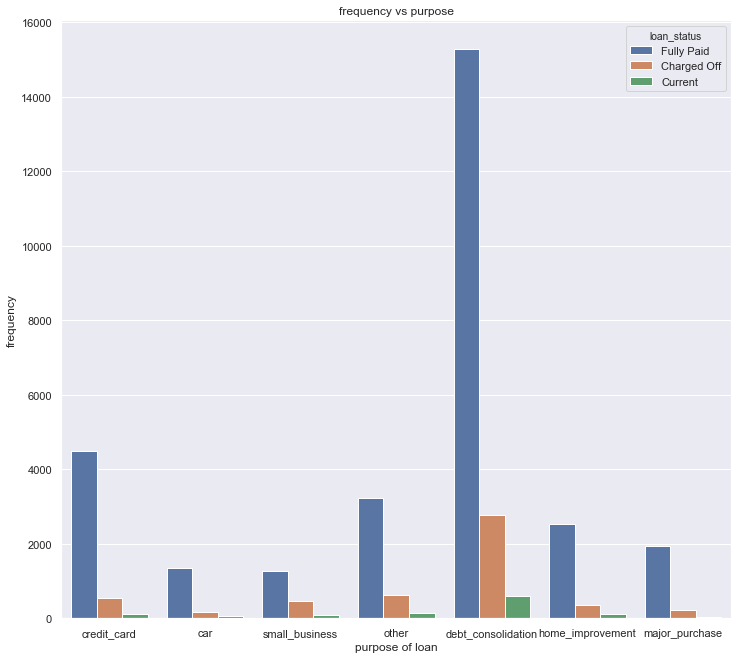

In [15]:
# 3.1.1 Purpose of loan
count_plot(loan_num, 'purpose', 'loan_status', 'purpose of loan', 'frequency', 'frequency vs purpose')

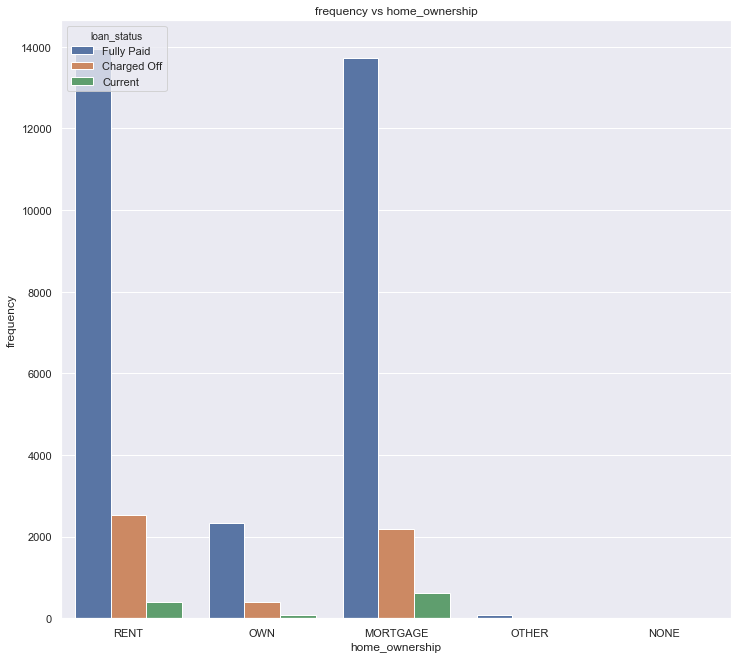

In [16]:
# 3.1.2 Home ownership
count_plot(loan_num, 'home_ownership', 'loan_status', 'home_ownership', 'frequency', 'frequency vs home_ownership')

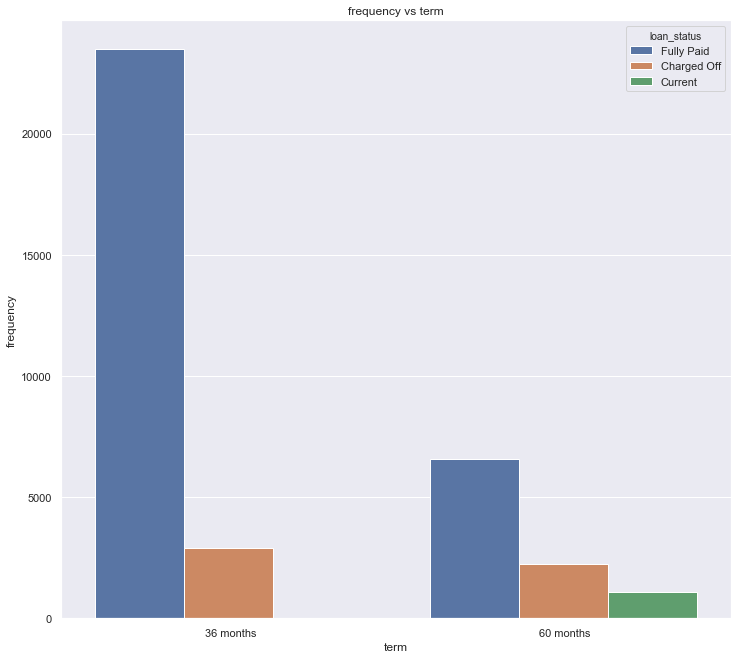

In [17]:
# 3.1.3 loan term
count_plot(loan_num, 'term', 'loan_status', 'term', 'frequency', 'frequency vs term')

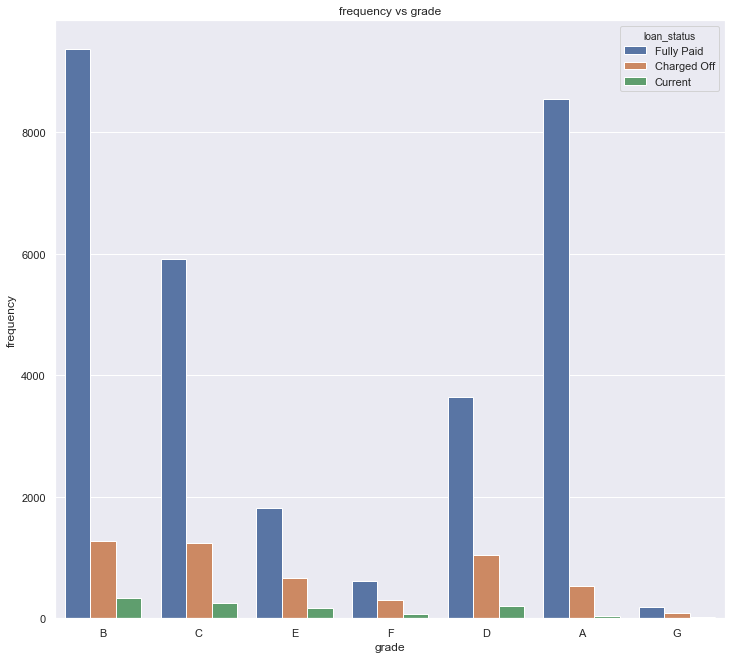

In [18]:
# 3.1.4 Loan grade
count_plot(loan_num, 'grade', 'loan_status', 'grade', 'frequency', 'frequency vs grade')

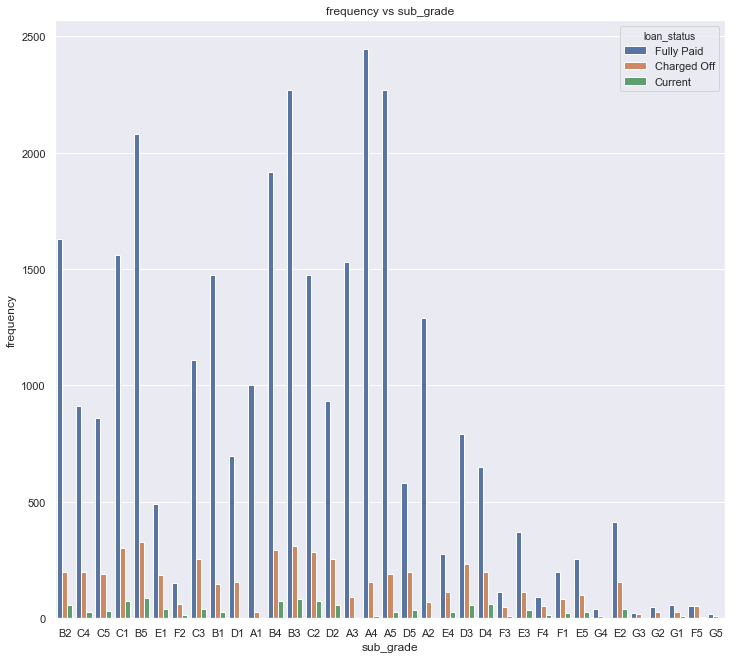

In [19]:
# 3.1.5 Loan sub_grade
count_plot(loan_num, 'sub_grade', 'loan_status', 'sub_grade', 'frequency', 'frequency vs sub_grade')

### 3.2 Segmented Univariate analysis
    Concept for bucket creation here.
    1. max value minus min value in data series defines the range of values we got.
    2. Base rule to have minimum of 5 buckets to maximum of 20 buckets
    3. Find a number which is very closely divisible to the range (from point 1)  and this number should lie between 5 to 20.
    4. Post division the value what we get is the interval of the buckets.

    For example:
    We have 
    min=5
    max=105
    range=max-min=105-5=100
    assuming 5 buckets as its divisible by 100.
    And 5 Buckets would be 0-20, 20-40, 40-60, 60-80, 80-100

#### 3.2.1 Create groups for range of loan amounts

    1000 >= & < 5000    ===> 7204
    5000 >= & < 10000   ===> 10127
    10000 >= & < 15000  ===> 6091
    15000 >= & < 20000  ===> 2965
    20000 >= & < 30000  ===> 3407
    30000 >=            ===> 828
    <= 1000             ===> 313

In [20]:
# 3.2.1 Create groups for range of loan amounts
loan_buckets = [0, 5000, 10000, 15000, 20000, 25000,40000]
loan_range = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000 and above']
loan_num['loan_amnt_range'] = pd.cut(loan_num['loan_amnt'], loan_buckets, labels=loan_range)
loan_num[['loan_amnt','loan_amnt_range']].head()

,loan_amnt,loan_amnt_range
0,5000,0-5000
1,2500,0-5000
2,2400,0-5000
3,10000,5000-10000
4,3000,0-5000


###### Inference:  71% of the loan applicants have applied for loan amount less than 20000

#### 3.2.2 Create buckets for range of annual income of the loan applicant

    Number of people in range based on annual income
    >10000 & <30000   ===> 5464
    >30000 & <50000   ===> 103
    > 50000       ===> 67
    <= 10000      ===> 34030

In [21]:
# 3.2.2 Create groups for range of annual income
annual_inc_buckets = [0, 25000, 50000, 75000, 100000,1000000]
annual_inc_range = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
loan_num['annual_inc_range'] = pd.cut(loan_num['annual_inc'], annual_inc_buckets, labels=annual_inc_range)
loan_num[['annual_inc','annual_inc_range']].head()

,annual_inc,annual_inc_range
0,24000.00,0-25000
1,30000.00,25000-50000
2,12252.00,0-25000
3,49200.00,25000-50000
4,80000.00,75000-100000


##### Inference: More than 85% of the people lie under a salary of less than 10000

#### 3.2.3 Create buckets for range of interest rates for the loan applicant(s)

    Number of people offered with interest rates
    >5  & <10 ===> 12142  
    >10 & <15 ===> 19045
    >15 & <20 ===> 7658
    >20 & <25 ===> 872

In [22]:
#3.2.3 Create buckets for range of interest rates for the loan applicant(s)
int_rate_buckets = [0, 7.5, 10, 12.5, 15, 20]
int_rate_brackets = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15 and above']
loan_num['int_rate_range'] = pd.cut(loan_num['int_rate'], int_rate_buckets, labels=int_rate_brackets)
loan_num[['int_rate','int_rate_range']].head()

,int_rate,int_rate_range
0,10.65,10-12.5
1,15.27,15 and above
2,15.96,15 and above
3,13.49,12.5-15
4,12.69,12.5-15


##### Inference: 31% loan applicant are within 10% interest.. 67% loan applicants are in the range of 10% to 20% interest rate

### 3.3 Quantitative
    3.3.1 Loan amount
    3.3.2 Interest rate 
    3.3.3 Annual income

In [23]:
#Function to do quantitative analysis on columns
def quant_plot(df,column):
    fig, ax=plt.subplots(nrows =1,ncols=3,figsize=(20,8))
    ax[0].set_title("Distribution Plot")
    sns.distplot(df[column], ax=ax[0])
    ax[1].set_title("Violin Plot")
    sns.violinplot(data =df, x=df[column],ax=ax[1], inner="quartile")
    ax[2].set_title("Box Plot")
    sns.boxplot(data =df, x=df[column], ax=ax[2], orient='v')

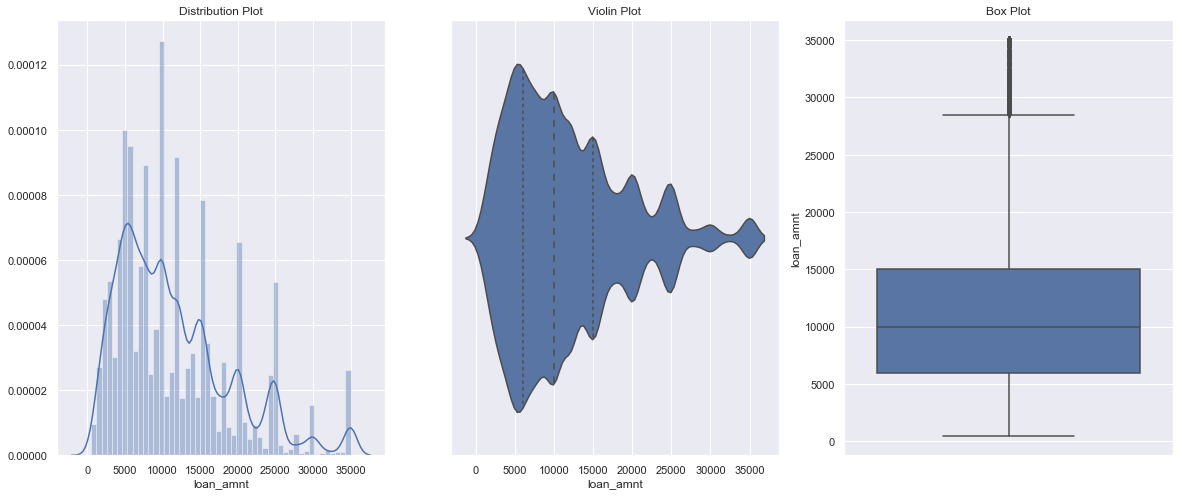

In [24]:
# 3.3.1 Loan amount
quant_plot(loan_num, 'loan_amnt')

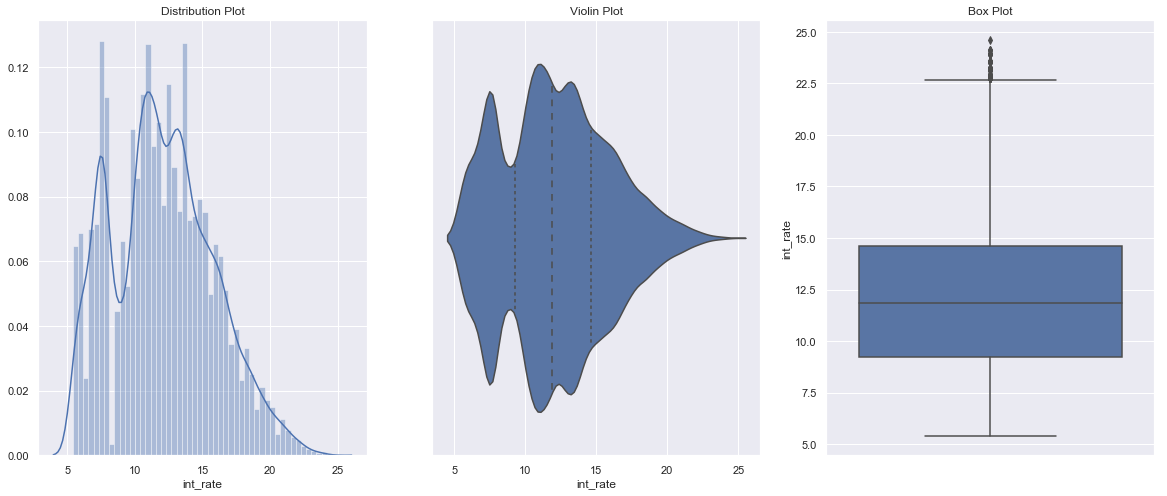

In [25]:
# 3.3.2 Interest rate 
quant_plot(loan_num, 'int_rate')

In [26]:
# 3.3.3 Annual income
loan_num["annual_inc"].describe()

count     36304.00
mean      69240.66
std       64630.79
min        4080.00
25%       41000.00
50%       60000.00
75%       83000.00
max     6000000.00
Name: annual_inc, dtype: float64

In [27]:
#max annual income is almost 80 times higher than the mean and the 75 percentile.
#Hence removing the outliers from 99.5 to 100 percentile

q = loan_num["annual_inc"].quantile(0.995)
loan_final = loan_num[loan_num["annual_inc"] < q]
loan_final["annual_inc"].describe()

count    36107.00
mean     66697.32
std      37397.67
min       4080.00
25%      41000.00
50%      59321.00
75%      82000.00
max     294000.00
Name: annual_inc, dtype: float64

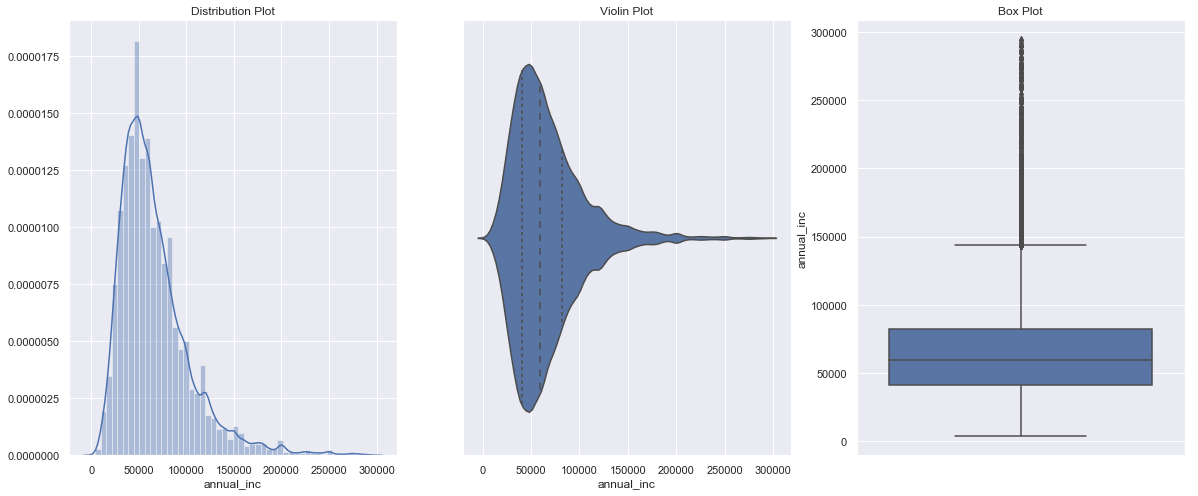

In [28]:
#plotting annual income post outlier treatment
quant_plot(loan_final, 'annual_inc')

### 4. Derived columns/metrics
    4.1 Loan amount to annual income ratio
    4.2 Derived month and year from loan issue date
    4.3 Loan term split to numeric
    4.4 year derived from the loan issue date

In [29]:
# 4.1 Loan amount to annnual income ratio
loan_num['loan_income_ratio']= loan_num['loan_amnt']/loan_num['annual_inc']

In [30]:
# 4.2 Dervied month and year from loan issue date
loan_num['issue_month'],loan_num['issue_year'] = loan_num['issue_d'].str.split('-', 1).str
loan_num[['issue_d','issue_month','issue_year']].head()

,issue_d,issue_month,issue_year
0,Dec-11,Dec,11
1,Dec-11,Dec,11
2,Dec-11,Dec,11
3,Dec-11,Dec,11
4,Dec-11,Dec,11


In [31]:
# 4.3 Loan term split to numeric
term_split = loan_num['term'].str.split("months",n=1,expand=True)
loan_num['term_int']=term_split[0].astype('int64')
loan_num[['term','term_int']].head()

,term,term_int
0,36 months,36
1,60 months,60
2,36 months,36
3,36 months,36
4,60 months,60


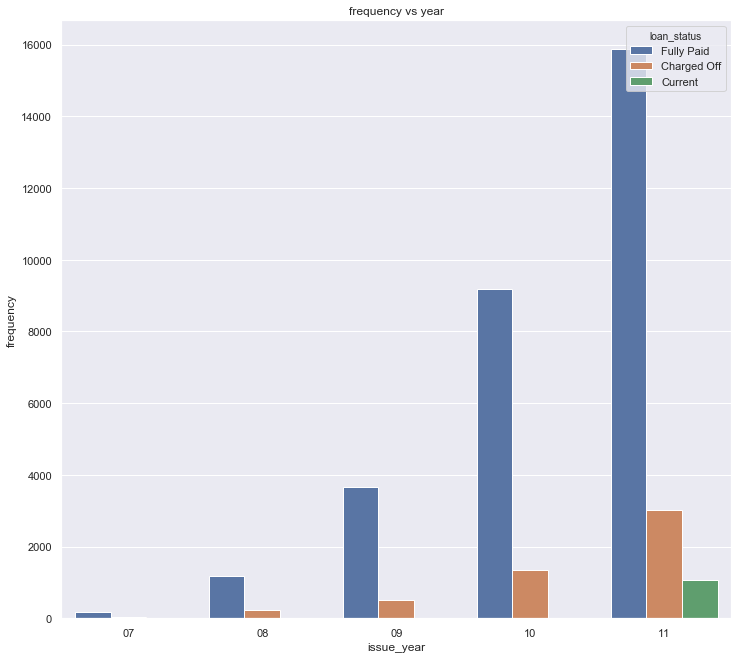

In [32]:
# 4.4 year dervied from the loan issue date
count_plot(loan_num, 'issue_year', 'loan_status', 'issue_year', 'frequency', 'frequency vs year')

##### Inference: Clearly the height of charged off in 36 months is more than 60 months

### 5. Bivariate analysis
    5.1 Purpose of loan vs loan amount for each loan status
    5.2 Bivariate corelation matrix with numeric values
    5.3 Frequency of loan status for given purpose and employee length
    5.4 Address_State vs Probability Charge Off
    5.5 Purpose of Loan vs Probability Charge Off
    5.6 Grade/Subgrade vs Probability Charge Off
    5.7 Annual Income Range vs Probability Charge Off
    5.8 Interest rate Range vs Probability Charge Off
    5.9 Employment Length vs Probability Charge Off
    5.10 Term converted to integer and probability vs charged off 

#### 5.1 Purpose of loan vs loan amount for each loan status

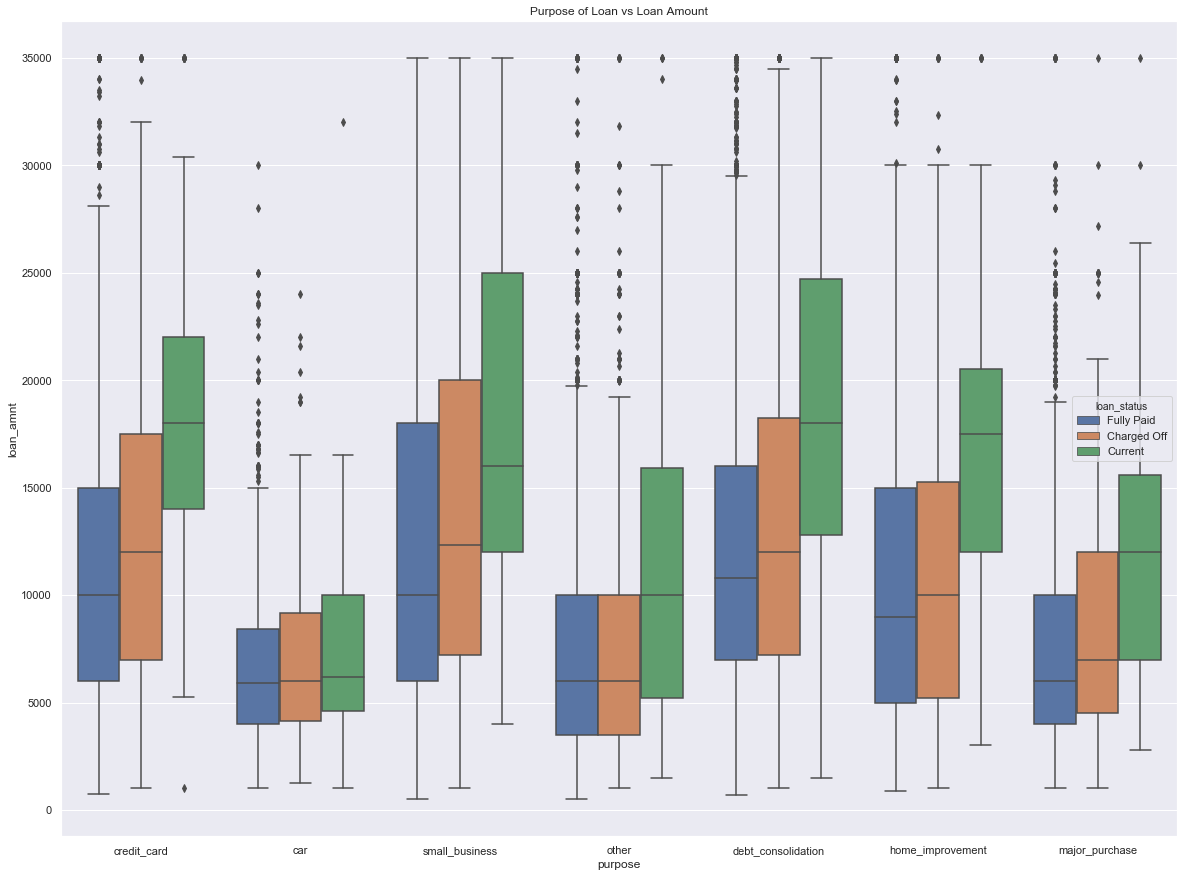

In [33]:
# 5.1 Purpose of loan vs loan amount for each loan status
plt.figure(figsize=(20,15))
sns.boxplot(data =loan_final, x='purpose', y='loan_amnt', hue ='loan_status')
plt.title('Purpose of Loan vs Loan Amount')
plt.show()

#### 5.2 Bivariate corelation matrix with numeric values

In [34]:
# 5.2 Bivariate corelation matrix with numeric values
loan_corr = loan_final.corr()
loan_corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti
loan_amnt,1.00,0.98,0.94,0.32,0.93,0.42,0.07
funded_amnt,0.98,1.00,0.96,0.32,0.95,0.41,0.07
funded_amnt_inv,0.94,0.96,1.00,0.31,0.90,0.39,0.08
int_rate,0.32,0.32,0.31,1.00,0.29,0.08,0.12
installment,0.93,0.95,0.90,0.29,1.00,0.42,0.06
annual_inc,0.42,0.41,0.39,0.08,0.42,1.00,-0.12
dti,0.07,0.07,0.08,0.12,0.06,-0.12,1.00


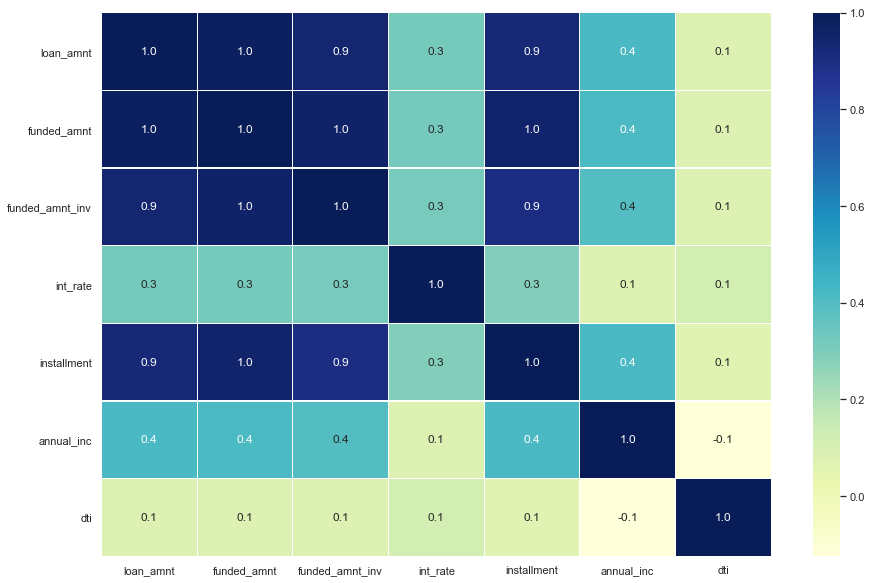

In [35]:
    f, ax = plt.subplots(figsize =(15, 10)) 
    sns.heatmap(loan_corr, ax = ax, cmap ="YlGnBu", linewidths = 0.1, annot=True,fmt=".1f") 
    plt.show()

##### Inference - columns like loan_amnt, funded_amnt and funded_amnt_inv are highly corelated columns

#### 5.3 Frequency of loan status for given purpose and employee length

In [36]:
# 5.3 Frequency of loan status for given purpose and employee length
loanstatus=loan_final.pivot_table(index=['loan_status', 'purpose', 'emp_length'], values= 'loan_amnt', aggfunc=('count')).reset_index()
loanstatus=loan_final.loc[loan_final['loan_status']=='Charged Off']
loanstatus

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,loan_amnt_range,annual_inc_range,int_rate_range
1,2500,2500,2500.00,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,car,bike,GA,1.00,0,Apr-99,5,3,0,1687,9.40%,4,0,0,1008.71,1008.71,456.46,435.17,0,117.08,1.11,Apr-13,119.66,Sep-13,0,0-5000,25000-50000,15 and above
8,5600,5600,5600.00,60 months,21.28,152.39,F,F2,NaN,4 years,OWN,40000.00,Source Verified,Dec-11,Charged Off,small_business,Expand Business & Buy Debt Portfolio,CA,5.55,0,Apr-04,2,11,0,5210,32.60%,13,0,0,646.02,646.02,162.02,294.94,0,189.06,2.09,Apr-12,152.39,Aug-12,0,5000-10000,25000-50000,NaN
9,5375,5375,5350.00,60 months,12.69,121.45,B,B5,Starbucks,< 1 year,RENT,15000.00,Verified,Dec-11,Charged Off,other,Building my credit history.,TX,18.08,0,Sep-04,0,2,0,9279,36.50%,3,0,0,1476.19,1469.34,673.48,533.42,0,269.29,2.52,Nov-12,121.45,Mar-13,0,5000-10000,0-25000,12.5-15
12,9000,9000,9000.00,36 months,13.49,305.38,C,C1,Va. Dept of Conservation/Recreation,< 1 year,RENT,30000.00,Source Verified,Dec-11,Charged Off,debt_consolidation,freedom,VA,10.08,0,Apr-04,1,4,0,10452,91.70%,9,0,0,2270.7,2270.7,1256.14,570.26,0,444.3,4.16,Jul-12,305.38,Nov-12,0,5000-10000,25000-50000,12.5-15
14,10000,10000,10000.00,36 months,10.65,325.74,B,B2,SFMTA,3 years,RENT,100000.00,Source Verified,Dec-11,Charged Off,other,Other Loan,CA,7.06,0,May-91,2,14,0,11997,55.50%,29,0,0,7471.99,7471.99,5433.47,1393.42,0,645.1,6.3145,Oct-13,325.74,Mar-14,0,5000-10000,75000-100000,10-12.5
21,21000,21000,21000.00,36 months,12.42,701.73,B,B4,Osram Sylvania,10+ years,RENT,105000.00,Verified,Dec-11,Charged Off,debt_consolidation,Debt Cleanup,FL,13.22,0,Feb-83,0,7,0,32135,90.30%,38,0,0,14025.4,14025.4,10694.96,3330.44,0,0,0,Sep-13,701.73,May-16,0,20000-25000,100000 and above,10-12.5
24,6000,6000,6000.00,36 months,11.71,198.46,B,B3,bmg-educational,1 year,RENT,76000.00,Not Verified,Dec-11,Charged Off,major_purchase,cash,CA,2.40,0,Jun-01,1,7,0,5963,29.70%,7,0,0,2050.14,2050.14,1305.58,475.25,0,269.31,2.57,Oct-12,198.46,Mar-13,0,5000-10000,75000-100000,10-12.5
26,15000,15000,8725.00,36 months,14.27,514.64,C,C2,nyc transit,9 years,RENT,60000.00,Not Verified,Dec-11,Charged Off,debt_consolidation,consolidation,NY,15.22,0,Oct-03,1,7,0,5872,57.60%,11,0,0,0,0,0,0,0,0,0,NaN,0,May-16,0,10000-15000,50000-75000,12.5-15
27,5000,5000,5000.00,60 months,16.77,123.65,D,D2,Frito Lay,2 years,RENT,50004.00,Not Verified,Dec-11,Charged Off,other,Other,PA,13.97,3,Oct-03,0,14,0,4345,59.50%,22,0,0,1609.12,1609.12,629.05,719.11,0,260.96,2.3,Dec-12,123.65,May-13,0,0-5000,50000-75000,15 and above
46,5000,5000,5000.00,36 months,8.90,158.77,A,A5,STERIS Corporation,10+ years,MORTGAGE,100000.00,Source Verified,Dec-11,Charged Off,debt_consolidation,Debt Consolidation for a better life,OH,16.33,0,Jun-95,0,17,0,74351,62.10%,35,0,0,5021.37,5021.37,4217.38,696.99,0,107,1.07,Aug-14,158.77,Dec-14,0,0-5000,75000-100000,7.5-10


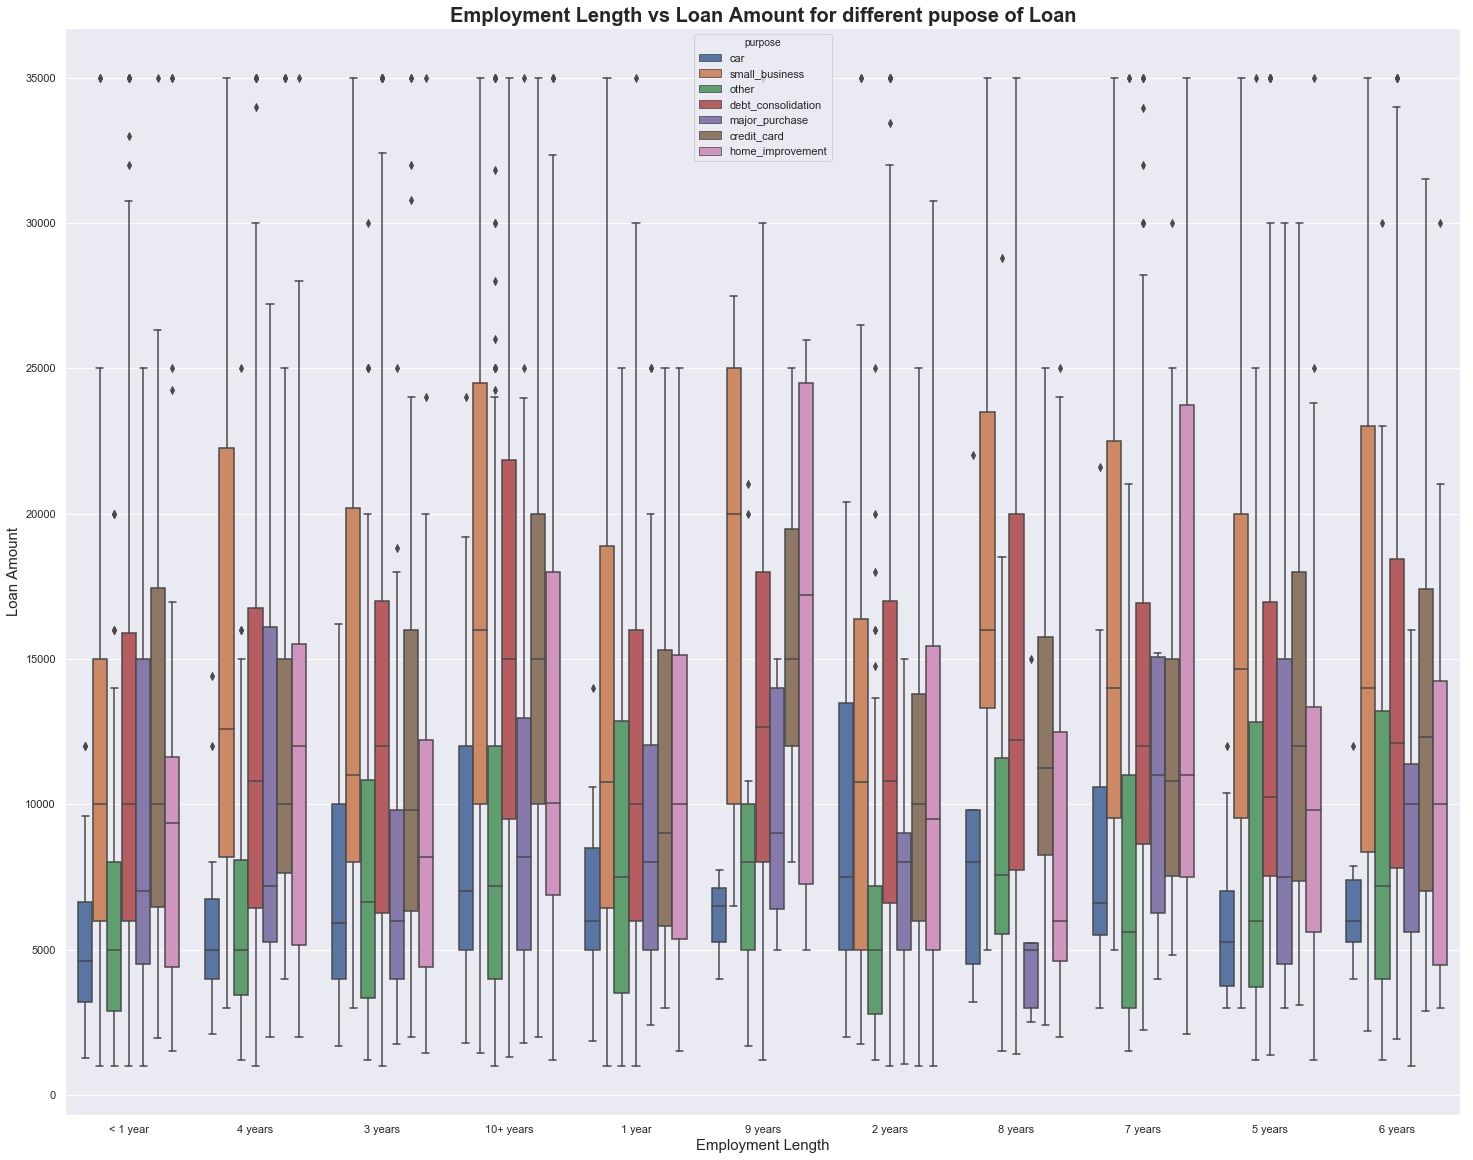

In [37]:
ax = plt.figure(figsize=(25, 20))
ax = sns.boxplot(x='emp_length',y='loan_amnt',hue='purpose',data=loanstatus)
ax.set_title('Employment Length vs Loan Amount for different pupose of Loan',fontsize=20,weight="bold")
ax.set_xlabel('Employment Length',fontsize=15)
ax.set_ylabel('Loan Amount',fontsize=15)
plt.show()

##### Inference: Loan applicants years of experience would matter the loan of amount sanctioned as well a trade off with loan status

#### Crosstab : To have a simple frequency distribution matrix
    Calculation probablity of charged off as p=number of charged off/total loan applicants

In [38]:
    def crosstab(df,col):
        '''
        df : Dataframe
        col: Column Name
        '''
        crosstab = pd.crosstab(df[col], df['loan_status'],margins=True)
        crosstab['Probability_Charged Off'] = round((crosstab['Charged Off']/crosstab['All']),3)
        crosstab = crosstab[0:-1]
        return crosstab

##### Function for plotting bivariate graphs

In [39]:
    def bivariate_prob(df,col,stacked= True):
        '''
        df      : Dataframe
        col     : Column Name
        stacked : True(default) for Stacked Bar
        '''
        # get dataframe from crosstab function
        plotCrosstab = crosstab(df,col)

        linePlot = plotCrosstab[['Probability_Charged Off']]      
        barPlot =  plotCrosstab.iloc[:,0:2]
        ax = linePlot.plot(figsize=(20,8), marker='o',color = 'b')
        ax2 = barPlot.plot(kind='bar',ax = ax,rot=1,secondary_y=True,stacked=stacked)
        ax.set_title(df[col].name.title()+' vs Probability Charge Off',fontsize=20,weight="bold")
        ax.set_xlabel(df[col].name.title(),fontsize=14)
        ax.set_ylabel('Probability of Charged off',color = 'b',fontsize=14)
        ax2.set_ylabel('Number of Applicants',color = 'g',fontsize=14)
        plt.show()

#### 5.4 Location (Address_State) vs Probability Charge Off

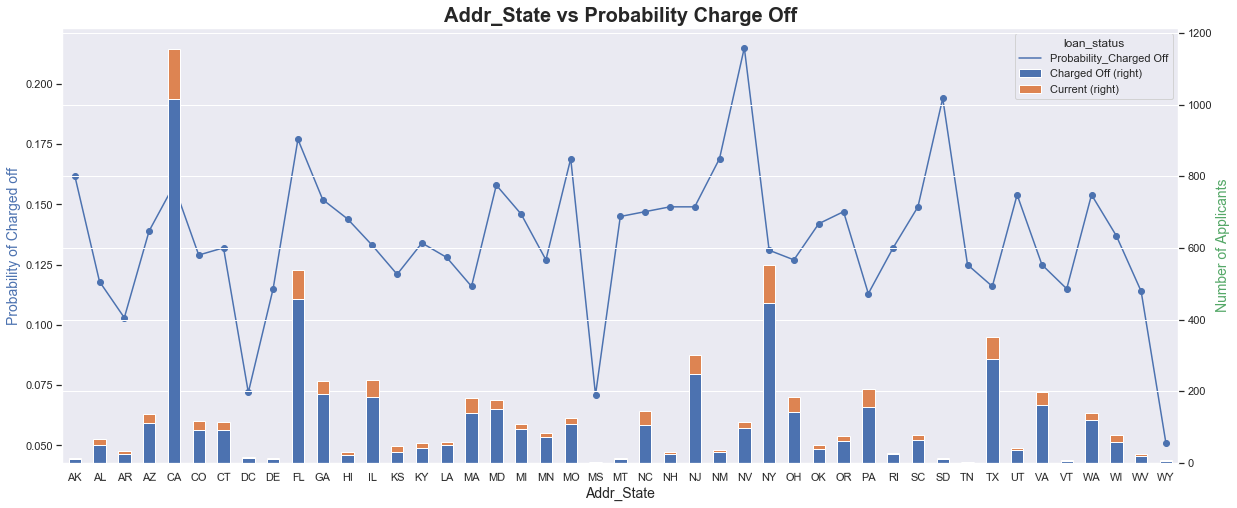

In [40]:
# 5.4 Address_State vs Probability Charge Off

filter_states = loan_final.addr_state.value_counts()
filter_states = filter_states[(filter_states < 10)]

loan_filter_states = loan_final.drop(labels = loan_final[loan_final.addr_state.isin(filter_states.index)].index)
#loan_filter_states

states = crosstab(loan_filter_states,'addr_state')
#display(states.head(20))

bivariate_prob(df =loan_filter_states,col ='addr_state')

 ##### Inference:  There are multiple States/Provinces with high probability of charge off, among which highest being 'NV' above 20%

#### 5.5 Purpose of Loan vs Probability Charge Off

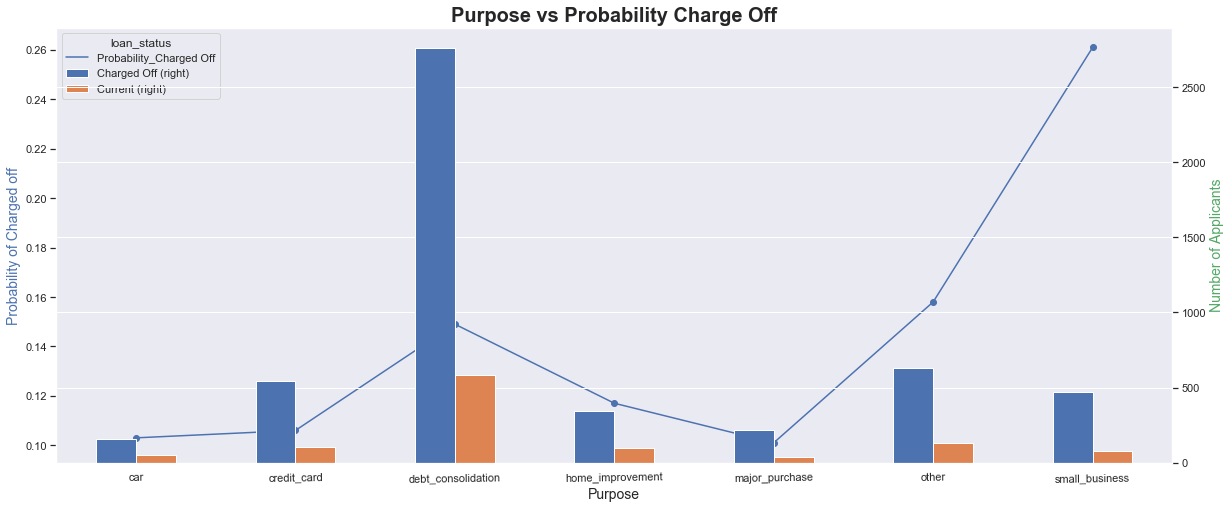

In [41]:
# 5.5 Purpose of Loan vs Probability Charge Off
purpose = crosstab(loan_final,'purpose')
#display(purpose)

bivariate_prob(df =loan_final,col ='purpose',stacked=False)    

##### Inference: Applicants who has taken the Loan with purpose of 'small business' has the highest probabilty of charge off of 26%. So loan lending company needs to take extra care about these 'small business' applicants. (probablity some mortage as an exchange of security).

#### 5.6 Grade/Subgrade vs Probability Charge Off

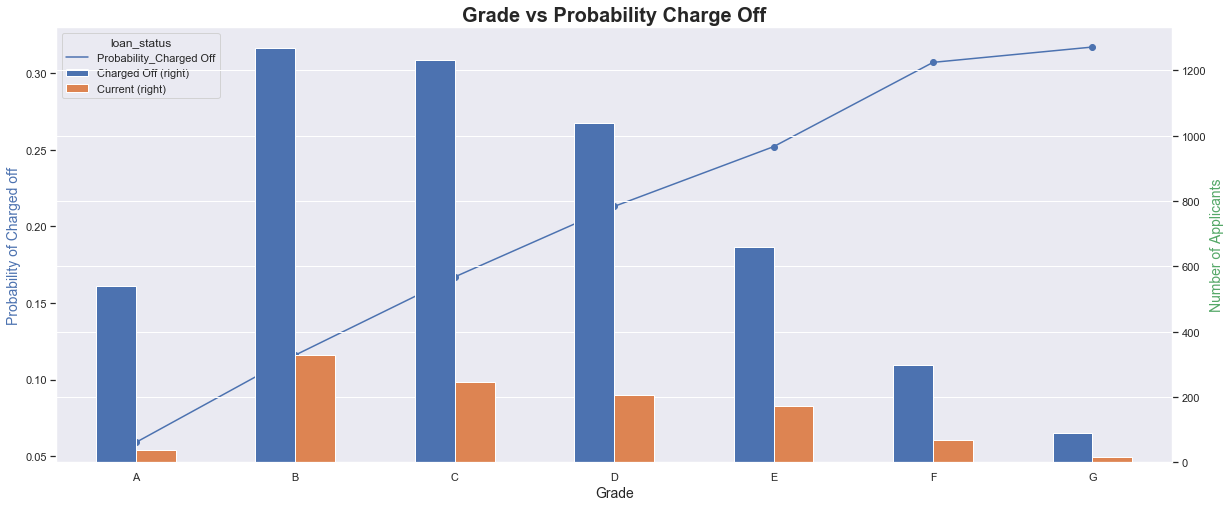

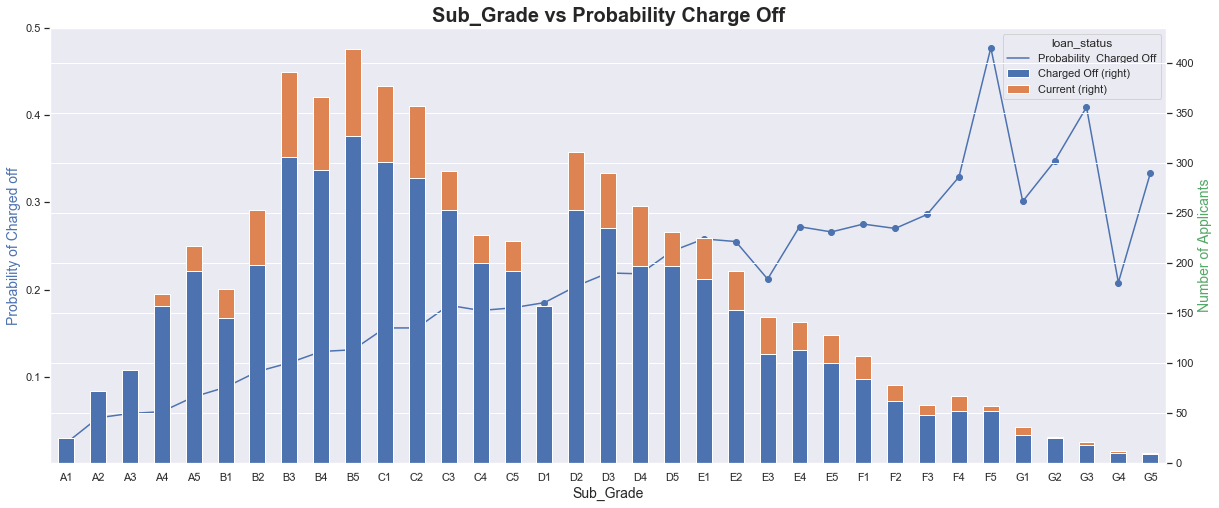

In [42]:
# 5.6 Grade/Subgrade vs Probability Charge Off
grade = crosstab(loan_final,'grade')
#display(grade)

bivariate_prob(df =loan_final,col ='grade',stacked=False)
bivariate_prob(df =loan_final,col ='sub_grade')

##### Inference: From grades A to G from left to right, probability of the applications be charged off are higher.

#### 5.7 Annual Income Range vs Probability Charge Off

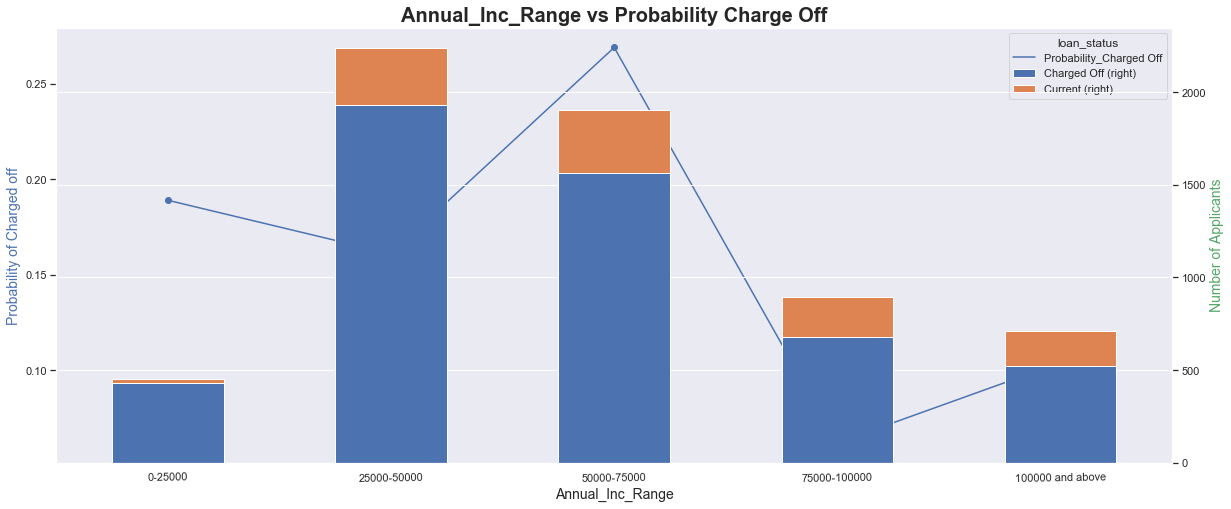

In [43]:
# 5.7 Annual Income Range vs Probability Charge Off
annual_inc_range = crosstab(loan_final,'annual_inc_range')
#display(annual_inc_range)

bivariate_prob(df =loan_final,col ='annual_inc_range')

##### Inference: 
        1. Annual income in the bracket of 0 - 25000 have a probablity of charged off nearing 20% 
        2. Annual income in the bracket of 50000 - 750000 have a probablity of charge off more than 25%

#### 5.8 Interest rate Range vs Probability Charge Off

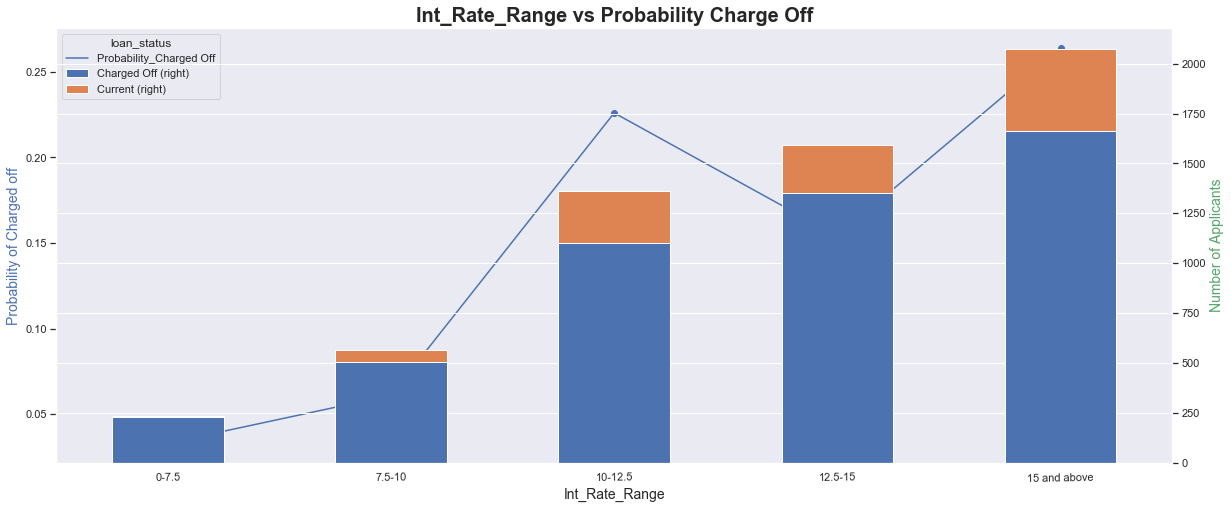

In [44]:
# 5.8 Interest rate Range vs Probability Charge Off
int_rate_range = crosstab(loan_final,'int_rate_range')
#display(int_rate_range)

bivariate_prob(df = loan_final, col ='int_rate_range')

##### Inference:
    1. We see two peaks here, one at interest rate range of 10 to 12.5% with a probablity of charged off being 22.5%
    2. Second peak at 25% with an interest rate above 15%
    But a steady increase past 15%

#### 5.9 Employment Length vs Probability Charge Off

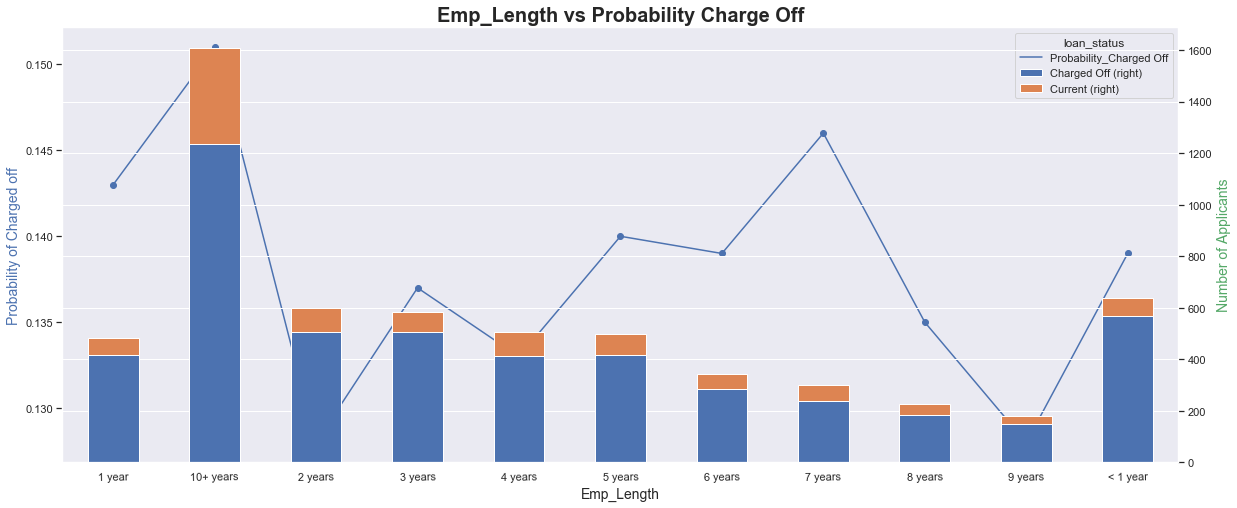

In [45]:
# 5.9 Employment Length vs Probability Charge Off
emp_length = crosstab(loan_final,'emp_length')
#Sdisplay(emp_length)

bivariate_prob(df =loan_final,col ='emp_length')

##### Inference: Applicants less than 1 year and 0 year considered as self employeed are more probable to be charged off.

#### 5.10 Term converted to integer and probability vs charged off

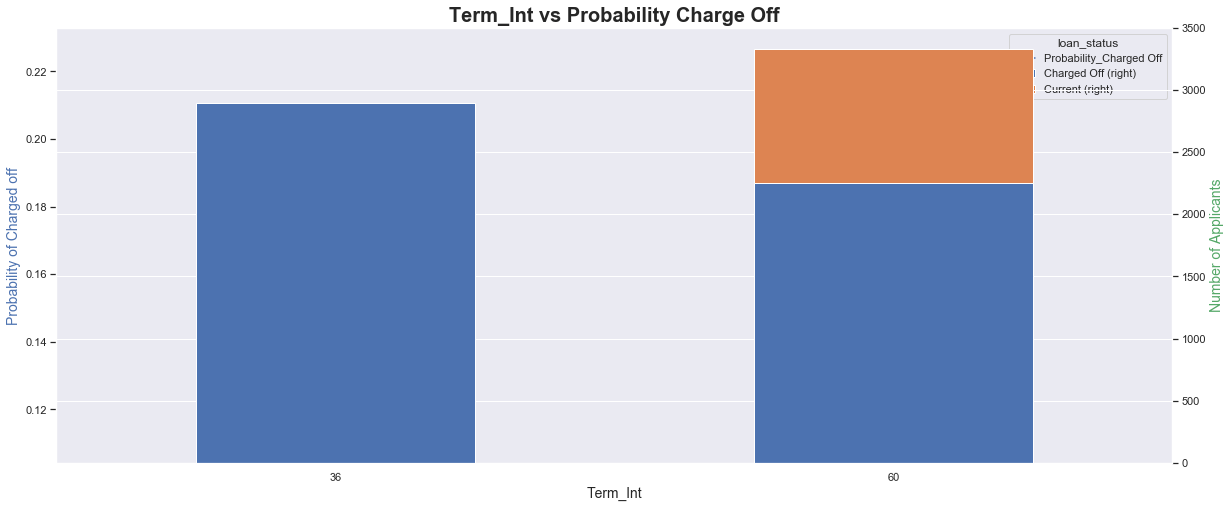

In [46]:
# 5.10 Term converted to integer and probability vs charged off 
term_int = crosstab(loan_num,'term_int')
# display(term_int)

bivariate_prob(df = loan_num, col ='term_int')

##### Inference: 60 months of loan have more probablity of charged off

In [47]:
# 5.11 Emp title comparison against loan status and mediam of annual income 
loan_df['emp_title'] = loan_df.emp_title.str.upper()
loan_emt = loan_df[['emp_title','loan_status']]
loan_emt = loan_emt.dropna()

import re
loan_emt['emp_title'] = loan_emt['emp_title'].map(lambda x: re.sub(r'\W+', ' ', x))


##### Inference: The below emp titles with annual income of < 40000 had the highest probability of charged off .
    - At&T
    - Bank of America
    - UPS
    - US Army
    - WalMart

### 6. Conclusion

   ###### Objective:
        The company wants to understand the driving factors (or driver variables) behind loan default, 
        i.e. the variables which are strong indicators of default. 
            
   ###### Primary Inferences:
        - 71% of the loan applicants have applied for loan amount less than 20000
        - More than 85% of the people lie under a salary of less than 10000
        - 31% loan applicant are within 10% interest 
        - 67% loan applicants are in the range of 10% to 20% interest rate
        - Clearly the height of charged off in 36 months is more than 60 months
        - Applicants years of experience would matter the loan of amount sanctioned as well a trade off with loan status
        - There are multiple States/Provinces with high probability of charge off, among which highest being 'NV' above 20%
        - From grades A to G from left to right, probability of the applications be charged off are higher.	
        - Annual income in the bracket of 0 - 25000 have a probablity of charged off nearing 20% 
        - Annual income in the bracket of 50000 - 750000 have a probablity of charge off more than 25%
        - I have two peaks here, one at interest rate range og 10 to 12.5% with a probablity of charged off being 22.5%. 
          Second peak at 25% with an interest rate above 15%
        - Applicants less than 1 year and 0 year considered as self employeed are more probable to be charged off.
        - 60 months of loan have more probablity of charged off
        - A set of emp titles with median annual income of < 45000 show high probability of charged off.

Driving factors/variables:

1. Employment Parameters
    - Employment length --
        Applicants years of experience would matter the loan of amount sanctioned as well a trade off with loan status
        Applicants less than 1 year and 0 year considered as self employed are more probable to be charged off

    - Annual Income --
        Annual income in the bracket of 0 - 25000 have a probability of charged off nearing 20%
        Annual income in the bracket of 50000 - 750000 have a probability of charge off more than 25%

    - Employment Title--
        A set of emp titles (At&T, Bank of America, UPS, US Army, WalMart) combined with median annual income of < 45000 show
        high probability of charged off.

2. Purpose of loan 
    - Debt consolidation, Others and Small Business are the purposes with high risk of Charged off.
    - Applicants who has taken the Loan with purpose of 'small business' has the highest probability of charged off of 26%.

3. Loan Parameters:
    - Term of the loan --
        60 months of loan have more probability of charged off

    - Interest rate --
        Interest rate range of 10 to 12.5% with a probability of charged off being 22.5%
        Second peak at 25% with an interest rate above 15%

4. Grade, Sub-grade
    - From grades A to G, higher the grade the probability of charged off increases.

5. Location
    - ‘NV’ States/Provinces has highest probability of charge off with 20%
    - SD, FL, MO, NM, AK, CA are other states with higher probability of Charged off
    
#################################################################################################################